In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl

import time
import sys

In [26]:
class TreeParityMachine:
	def __init__(self, N, K, L):
		self.N = N
		self.K = K
		self.L = L
		self._r()

	def _r(self):
		self.W = np.random.randint(-self.L, self.L + 1, size=(self.K, self.N))
    
	def sample_X(self):
		return np.random.randint(-self.L, self.L + 1, size=(self.K,  self.N))
	
	def forward(self, X):
		self.X = X.reshape((self.K, self.N))
		self.sgn = np.sign((self.W * self.X).sum(axis=1))
		self.y = self.sgn.prod()
		return self.y

	def update(self, y_other, update_rule='hebian'):
		if (self.y == y_other):
			if update_rule == 'hebbian':
				self.hebbian(y_other)
			elif update_rule == 'anti_hebbian':
				self.anti_hebbian(y_other)
			elif update_rule == 'random_walk':
				self.random_walk(y_other)
			else:
				raise Exception("Invalid update rule. Valid update rules are: " + 
				"\'hebbian\', \'anti_hebbian\' and \'random_walk\'.")
			
	def hebbian(self, y_other):
		self.W += self.X * self.y * (self.sgn.reshape((-1, 1)) == self.y) * (self.y == y_other)
		self.W = np.clip(self.W, -self.L, self.L+1)

	def anti_hebbian(self, tau2):
		self.W -= self.X * self.y * (self.sgn.reshape((-1, 1)) == self.y) * (self.y == tau2)
		self.W = np.clip(self.W, -self.L, self.L+1)

	def random_walk(self, tau2):
		self.W -= self.X * (self.sgn.reshape((-1, 1)) == self.y) * (self.y == tau2)
		self.W = np.clip(self.W, -self.L, self.L+1)


In [27]:
def test_sync(k, n, l, update_rule='hebbian', echo=False, max_time=float('inf')):

	A = TreeParityMachine(n, k, l)
	B = TreeParityMachine(n, k, l)
	E = TreeParityMachine(n, k, l)

	def sync_score(m1, m2):
		return 1.0 - np.average(1.0 * np.abs(m1.W - m2.W)/(2 * l))

	sync = False 
	updates = 0
	eve_updates = 0 
	scores = [] 
	eve_scores = []

	t1 = time.time()
	while(not sync):

		X = A.sample_X()

		y_A = A.forward(X) 
		y_B = B.forward(X) 
		y_E = E.forward(X) 
		A.update(y_B, update_rule)
		B.update(y_A, update_rule)
		updates += 1

		if y_A == y_B == y_E:
			E.update(y_A, update_rule)
			eve_updates += 1

		score = sync_score(A, B) 
		scores.append(score)
		score_EA = sync_score(A, E)
		score_EB = sync_score(B, E)
		eve_scores.append((score_EA, score_EB))
		sync = score == 1
		if echo:
			sys.stdout.write('\r' + "Synchronization = " + str(int(score * 100)) + "%   /  Updates = " + str(updates) + " / Eve's updates = " + str(eve_updates)) 


	time_taken = time.time() - t1

	if echo:
		if sync:
			print('\nAlice and Bob are synchronized.')
		if eve_scores[-1][0] == 1:
			print('Eve is also synchornized !!!')
	return {'synced': (A.W == B.W).all(), 'time': time_taken, 'updates': updates, 'eve_updates': eve_updates, 'alice': A, 'bob': B, 'eve': E, 'scores': np.array(scores), 'eve_scores': np.array(eve_scores)}


In [28]:
update_rules = ['hebbian', 'anti_hebbian', 'random_walk']

res = test_sync(k=50, n=30, l=2, update_rule='anti_hebbian', echo=True, max_time=5)

Synchronization = 100%   /  Updates = 10268 / Eve's updates = 5527
Alice and Bob are synchronized.


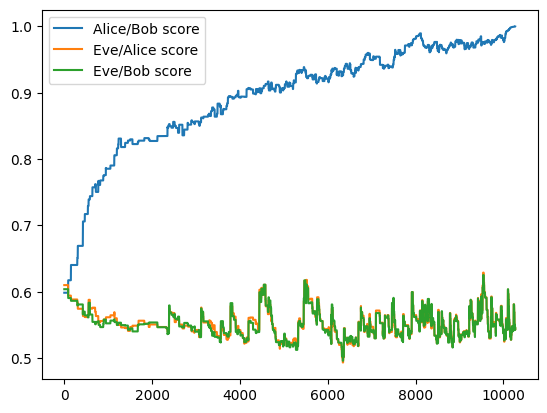

In [33]:
scores = res['scores']
eve_scores= res['eve_scores']
r = range(res['updates'])

mpl.plot(scores)
mpl.plot(eve_scores[:, 0])
mpl.plot(eve_scores[:, 1])
plt.legend(['Alice/Bob score', 'Eve/Alice score', 'Eve/Bob score'])

In [31]:
res

{'synced': True,
 'time': 1.2046802043914795,
 'updates': 10268,
 'eve_updates': 5527,
 'alice': <__main__.TreeParityMachine at 0x7fdb1b197310>,
 'bob': <__main__.TreeParityMachine at 0x7fdb1bc19a80>,
 'eve': <__main__.TreeParityMachine at 0x7fdb1bb3e4d0>,
 'scores': array([0.5985    , 0.5985    , 0.5985    , ..., 0.99983333, 0.99983333,
        1.        ]),
 'eve_scores': array([[0.61      , 0.60383333],
        [0.61      , 0.60383333],
        [0.61      , 0.60383333],
        ...,
        [0.5425    , 0.54233333],
        [0.5425    , 0.54233333],
        [0.545     , 0.545     ]])}